In [25]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

SEED = 42
random.seed(SEED)
np.random.seed(SEED)    

In [26]:
def generate_machen(length, dt=0.01, alpha=3, beta=0.1, gamma=1,noise=0.0, seed=None, initial_state=None):
    """
    Generate a trajectory of the Ma-Chen financial system.

    Args:
        length         (int):      Number of time steps to generate.
        dt             (float):    Time step size.
        alpha          (float):    Parameter alpha (savings rate).
        beta           (float):    Parameter beta (investment cost).
        gamma          (float):    Parameter gamma (demand elasticity).
        noise          (float):    Std-dev of additive Gaussian noise on each variable.
        seed           (int/None): Random seed for reproducibility.
        initial_state  (array-like or None): Initial (u1, u2, u3). Random if None.

    Returns:
        t (np.ndarray): shape (length,) -> time vector
        traj (np.ndarray): shape (length, 3) -> the Ma-Chen system trajectory at each time.
    """
    rng = np.random.default_rng(seed)
    
    # Initialize state
    if initial_state is None:
        state = rng.standard_normal(3)
    else:
        state = np.array(initial_state, dtype=float)
    
    t = np.linspace(0, dt*(length-1), length)
    traj = np.zeros((length, 3))
    traj[0] = state

    def machen_rhs(s):
        u1, u2, u3 = s
        du1 = u3 + (u2 - alpha) * u1
        du2 = 1 - beta * u2 - u1**2
        du3 = -u1 - gamma * u3
        return np.array([du1, du2, du3])
    # u1—interest rate, u2—investment demand, u3—price index,
    # alpha—saving amount, beta—cost per investment, gamma—elasticity of demand in commercial markets.

    # 4th-order Runge–Kutta integration
    for i in range(1, length):
        s = traj[i-1]
        k1 = machen_rhs(s)
        k2 = machen_rhs(s + 0.5 * dt * k1)
        k3 = machen_rhs(s + 0.5 * dt * k2)
        k4 = machen_rhs(s + dt * k3)
        traj[i] = s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # Add Gaussian noise if requested
    if noise > 0:
        traj += rng.normal(scale=noise, size=traj.shape)

    return t, traj

def generate_machen_init(length: int,
                         init_state: np.ndarray,
                         seed: int,
                         dt: float = 0.01,
                         alpha: float = 3.0,
                         beta: float = 0.1,
                         gamma: float = 1.0,
                         noise: float = 0.0):
    """Generate a Ma-Chen financial system trajectory via 4th-order Runge-Kutta.

    Args:
        length (int): number of time steps.
        dt (float): integration step.
        alpha, beta, gamma (float): Ma-Chen parameters.
        init_state (sequence or None): (u1_0, u2_0, u3_0). If None, draw from N(0,1).
        seed (int|None): RNG seed for reproducibility (affects random init & noise).
        noise (float): Gaussian noise std-dev added to each state variable.

    Returns:
        t (np.ndarray): shape (length,) - time vector.
        traj (np.ndarray): shape (length, 3) - states (u1, u2, u3).
    """
    rng = np.random.default_rng(seed)

    # Initial condition
    if init_state is None:
        state = rng.standard_normal(3)
    else:
        state = np.asarray(init_state, dtype=float).copy()
        if state.shape != (3,):
            raise ValueError("init_state must be length-3 (u1, u2, u3)")

    t = np.linspace(0, dt*(length-1), length)
    traj = np.zeros((length, 3))
    traj[0] = state

    def machen_rhs(s):
        u1, u2, u3 = s
        du1 = u3 + (u2 - alpha) * u1
        du2 = 1 - beta * u2 - u1**2
        du3 = -u1 - gamma * u3
        return np.array([du1, du2, du3])

    # RK4 integration
    for i in range(1, length):
        s = traj[i-1]
        k1 = machen_rhs(s)
        k2 = machen_rhs(s + 0.5 * dt * k1)
        k3 = machen_rhs(s + 0.5 * dt * k2)
        k4 = machen_rhs(s + dt * k3)
        traj[i] = s + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    # Optional additive noise
    if noise > 0:
        traj += rng.normal(scale=noise, size=traj.shape)

    return t, traj


def split_train_val_test(u, y, train_frac=0.6, val_frac=0.2):

    if train_frac + val_frac >= 1.0:
        raise ValueError("train_frac + val_frac must be < 1.0")
    N = len(u)
    i_train = int(train_frac * N)
    i_val   = i_train + int(val_frac * N)

    return ((u[:i_train], y[:i_train]), (u[i_train:i_val], y[i_train:i_val]), (u[i_val:], y[i_val:]))

In [27]:
dt = 0.01
length=10000
np.random.seed(SEED) 
t, traj = generate_machen(length=10000, dt=0.01)

u = traj[:, 0]    # x(t)
y = traj[:, 1]    # y(t)
traj.shape

(10000, 3)

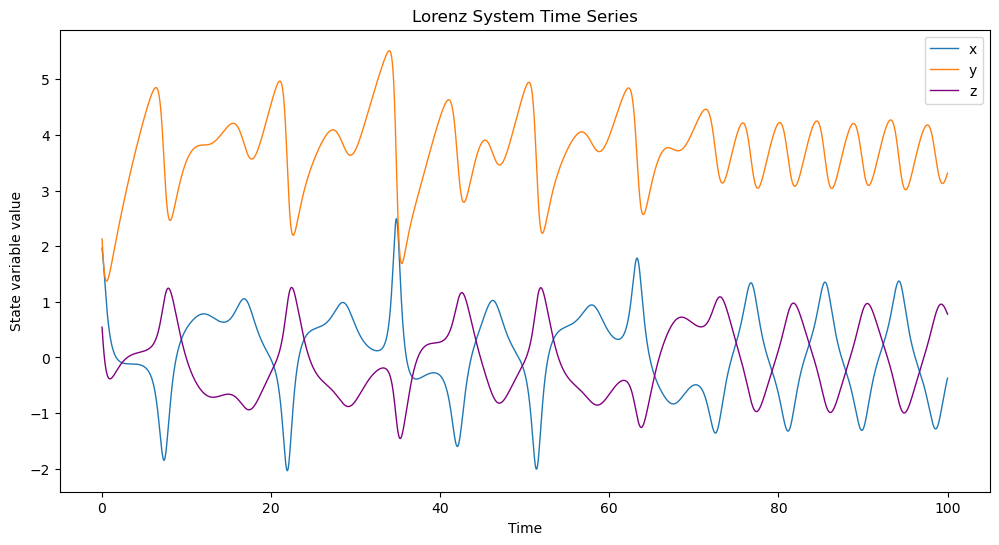

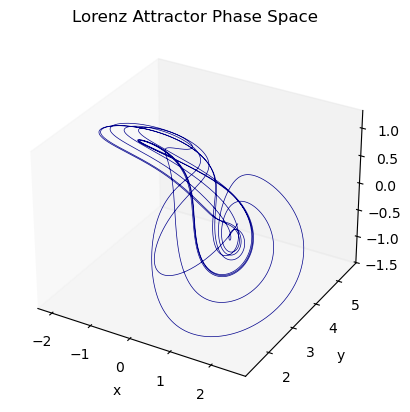

In [28]:
x, y, z = traj.T

# Plot time series
plt.figure(figsize=(12, 6))
plt.plot(t, x, lw= 1)
plt.plot(t, y, lw= 1)
plt.plot(t, z, color= "purple", lw= 1)
plt.xlabel('Time')
plt.ylabel('State variable value')
plt.title('Lorenz System Time Series')
plt.legend(['x', 'y', 'z'])
plt.show()

# Plot 3D phase-space attractor without grid
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z, lw=0.5, color='darkblue')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz Attractor Phase Space')
ax.grid(False)  
plt.show()

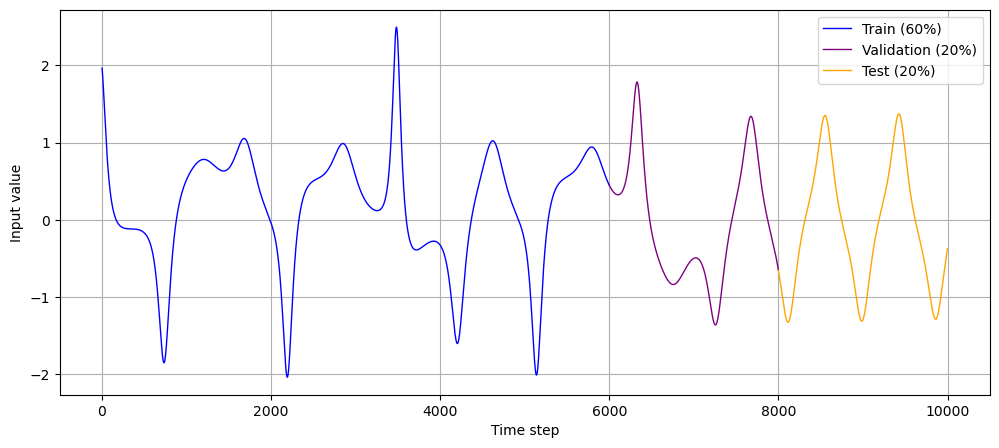

In [29]:
train_frac = 0.6
val_frac = 0.2

(u_tr, y_tr), (u_val, y_val), (u_te, y_te) = split_train_val_test(u, y, train_frac, val_frac)

i_train = len(u_tr)
i_val = i_train + len(u_val)
time = np.arange(length)

plt.figure(figsize=(12, 5))
plt.plot(time[:i_train], u_tr, label='Train (60%)', linewidth=1, color='blue')
plt.plot(time[i_train:i_val], u_val, label='Validation (20%)', linewidth=1, color='Purple')
plt.plot(time[i_val:], u_te, label='Test (20%)', linewidth=1, color='orange')

#plt.title(f'Lorentz-{n} Input Sequence by Dataset Split')
plt.xlabel('Time step')
plt.ylabel('Input value')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# deviazione standard di y_tr
std_y_tr = np.std(y_tr)
print(f"Standard deviation of y_tr: {std_y_tr:.4f}")
# deviazione standard di y_te
std_y_te = np.std(y_te)
print(f"Standard deviation of y_te: {std_y_te:.4f}")

Standard deviation of y_tr: 0.8050
Standard deviation of y_te: 0.4131


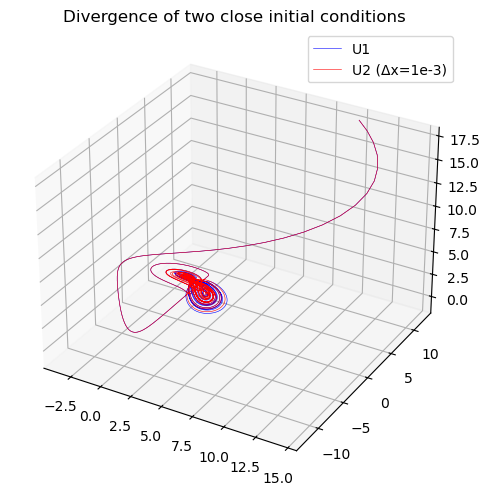

In [30]:
np.random.seed(SEED)  

init1 = np.array([10.0, 12.0, 18.0])
init2 = init1.copy()
init2[0] += 1e-3

steps = 20000
_, traj1 = generate_machen_init(length=steps, dt=dt, init_state=init1, seed = 42)
_, traj2 = generate_machen_init(length=steps, dt=dt, init_state=init2, seed = 42)

x1, y1, z1 = traj1.T
x2, y2, z2 = traj2.T

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1, y1, z1, lw=0.4, color='blue', label='U1')
ax.plot(x2, y2, z2, lw=0.4, color='red', label='U2 (Δx=1e‑3)')
ax.set_title('Divergence of two close initial conditions')
ax.legend()
plt.tight_layout(); plt.show()

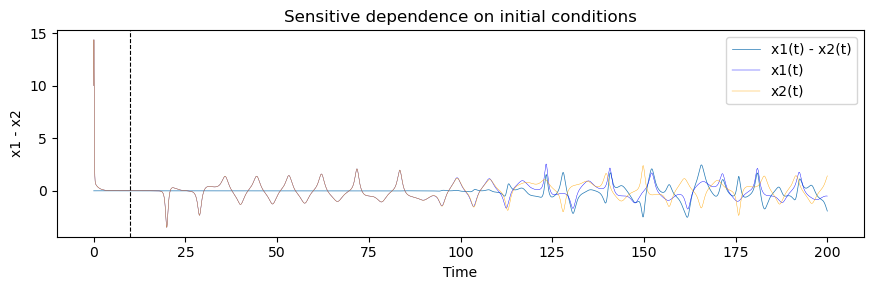

In [31]:

plt.figure(figsize=(9,3))
plt.plot(np.arange(steps)*dt, x1 - x2, label='x1(t) - x2(t)', lw=0.5)
plt.plot(np.arange(steps)*dt, x1 , color='blue', label='x1(t)', lw=0.3)
plt.plot(np.arange(steps)*dt, x2 , color='orange', label='x2(t)', lw=0.3)
plt.axvline(1000*dt, color='k', ls='--', lw=0.8)
plt.xlabel('Time'); plt.ylabel('x1 - x2')
plt.title('Sensitive dependence on initial conditions')
plt.legend()
plt.tight_layout(); plt.show()

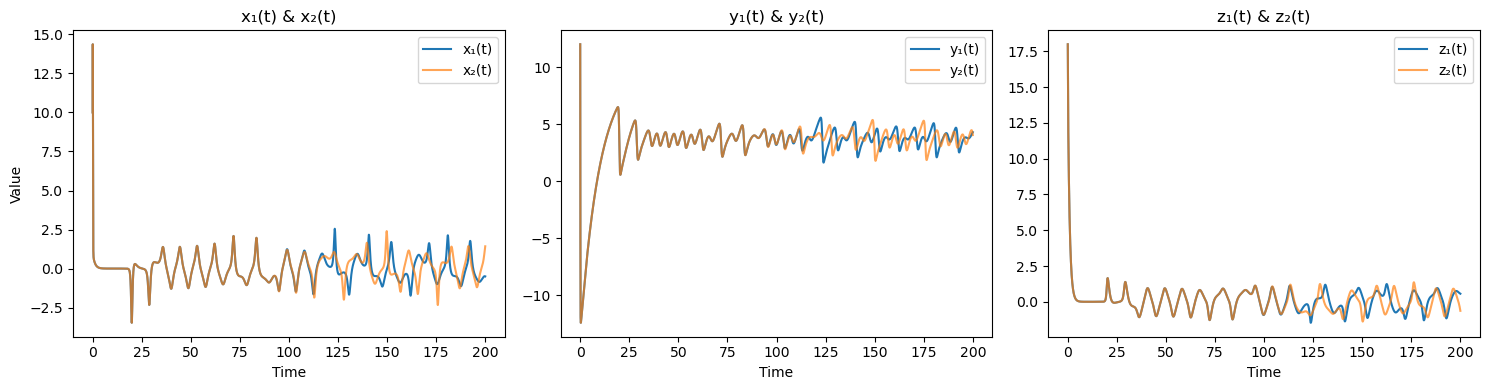

In [32]:

x1, y1, z1 = traj1.T
x2, y2, z2 = traj2.T
t = np.arange(len(x1)) * dt  # tempo in secondi
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

axes[0].plot(t, x1, label='x₁(t)')
axes[0].plot(t, x2, label='x₂(t)', alpha=0.7)
axes[0].set_title('x₁(t) & x₂(t)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Value')
axes[0].legend()

axes[1].plot(t, y1, label='y₁(t)')
axes[1].plot(t, y2, label='y₂(t)', alpha=0.7)
axes[1].set_title('y₁(t) & y₂(t)')
axes[1].set_xlabel('Time')
axes[1].legend()

axes[2].plot(t, z1, label='z₁(t)')
axes[2].plot(t, z2, label='z₂(t)', alpha=0.7)
axes[2].set_title('z₁(t) & z₂(t)')
axes[2].set_xlabel('Time')
axes[2].legend()

plt.tight_layout()
plt.show()


In [33]:
%pip install nolds

Note: you may need to restart the kernel to use updated packages.


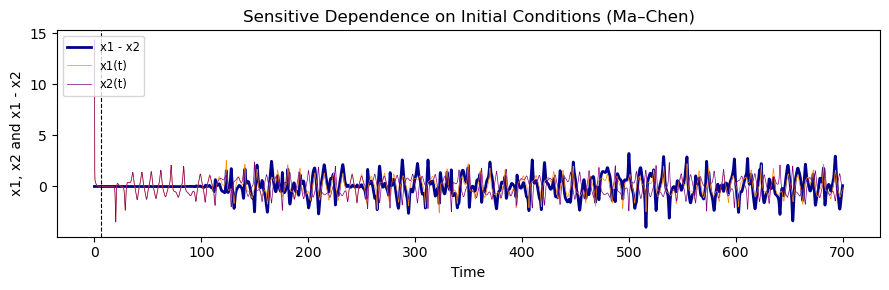

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) PARAMETERS ────────────────────────────────────────────────────────────
SEED   = 42
dt     = 0.01
steps  = 70000
t      = np.arange(steps) * dt   # time from 0 to (steps–1)*dt, i.e. [0, 700)

# Two initial states differing by 1e-3 in the x‐coordinate
np.random.seed(SEED)
init1 = np.array([10.0, 12.0, 18.0])
init2 = init1.copy()
init2[0] += 1e-3

# ── 2) GENERATE TRAJECTORIES ─────────────────────────────────────────────────

# Make sure generate_machen_init is actually using alpha=3, beta=0.1, gamma=1 inside
# (otherwise you won’t see the expected chaotic divergence).
_, traj1 = generate_machen_init(length=steps,
                                dt=dt,
                                init_state=init1,
                                seed=SEED,
                                alpha=3.0,    # Chaotic regime
                                beta=0.1,
                                gamma=1.0,
                                noise=0.0)

_, traj2 = generate_machen_init(length=steps,
                                dt=dt,
                                init_state=init2,
                                seed=SEED+1,  # Different seed to avoid identical noise
                                alpha=3.0,
                                beta=0.1,
                                gamma=1.0,
                                noise=0.0)

# Extract x‐component of each trajectory
x1 = traj1[:, 0]
x2 = traj2[:, 0]

# ── 3) PLOTTING ───────────────────────────────────────────────────────────────

plt.figure(figsize=(9, 3))
plt.plot(t, x1 - x2,     color='darkblue',  label='x1 - x2', lw=2)
plt.plot(t, x1,          color='darkorange',label='x1(t)',   lw=0.5)
plt.plot(t, x2,          color='purple',    label='x2(t)',   lw=0.5)

# Vertical line at step = 642 → time = 642 * dt = 6.42
plt.axvline(642 * dt, color='k', ls='--', lw=0.8)

plt.xlabel('Time')
plt.ylabel('x1, x2 and x1 - x2')
plt.title('Sensitive Dependence on Initial Conditions (Ma–Chen)')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

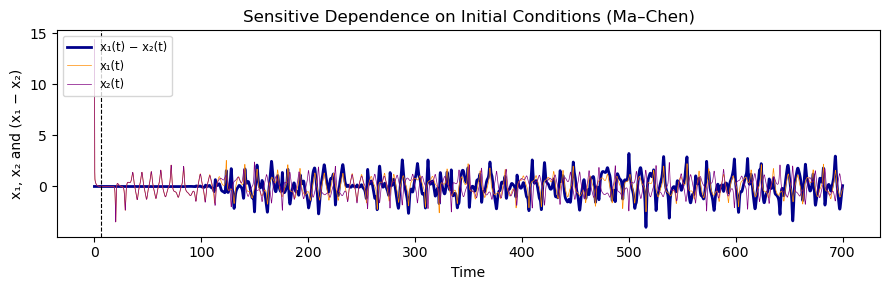

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) PARAMETERS ────────────────────────────────────────────────────────────
SEED   = 42
dt     = 0.01
steps  = 70000
t      = np.arange(steps) * dt   # time from 0 to ~700

# Chaos-forcing parameters
alpha = 3.0
beta  = 0.1
gamma = 1.0

# Two nearly identical initial states
np.random.seed(SEED)
init1 = np.array([10.0, 12.0, 18.0])
init2 = init1.copy()
init2[0] += 1e-3

# ── 2) GENERATE TRAJECTORIES ─────────────────────────────────────────────────

# (1) First trajectory with seed=42
_, traj1 = generate_machen_init(
    length=steps,
    dt=dt,
    init_state=init1,
    seed=SEED,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    noise=0.0
)

# (2) Second trajectory with seed=43 (different noise sequence—though noise=0 here,
#     using a different RNG seed still keeps them from matching any hidden randomness)
_, traj2 = generate_machen_init(
    length=steps,
    dt=dt,
    init_state=init2,
    seed=SEED + 1,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    noise=0.0
)

# Extract only the x‐component for plotting
x1 = traj1[:, 0]
x2 = traj2[:, 0]

# ── 3) PLOT x1, x2, AND x1–x2 WITH A VLINE AT STEP = 642 (t = 6.42) ──────────

plt.figure(figsize=(9, 3))
plt.plot(t, x1 - x2,  color='darkblue',  label='x₁(t) − x₂(t)', lw=2)
plt.plot(t, x1,       color='darkorange',label='x₁(t)',        lw=0.5)
plt.plot(t, x2,       color='purple',    label='x₂(t)',        lw=0.5)

# Draw vertical line at t = 642 * dt = 6.42
plt.axvline(642 * dt, color='k', ls='--', lw=0.8)

plt.xlabel('Time')
plt.ylabel('x₁, x₂ and (x₁ − x₂)')
plt.title('Sensitive Dependence on Initial Conditions (Ma–Chen)')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

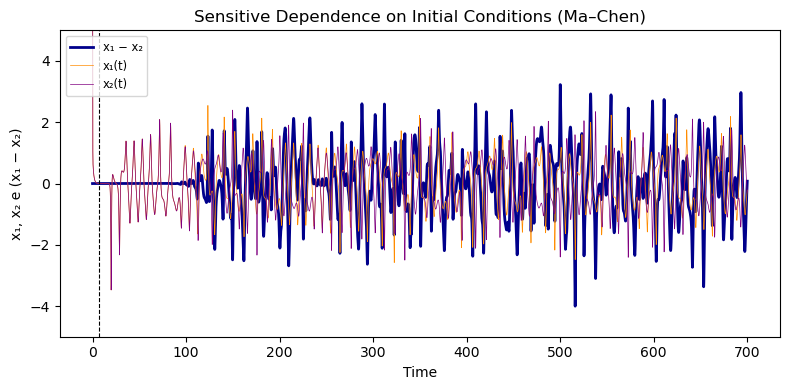

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# ── 1) PARAMETRI ──────────────────────────────────────────────────────────────
SEED   = 42
dt     = 0.01
steps  = 70000
t      = np.arange(steps) * dt   # va da 0 a ~700

alpha = 3.0
beta  = 0.1
gamma = 1.0

# Due condizioni iniziali a distanza 1e-3 su u1
np.random.seed(SEED)
init1 = np.array([10.0, 12.0, 18.0])
init2 = init1.copy()
init2[0] += 1e-3

# ── 2) GENERA TRAIETTORIE ────────────────────────────────────────────────────
_, traj1 = generate_machen_init(
    length=steps,
    dt=dt,
    init_state=init1,
    seed=SEED,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    noise=0.0
)
_, traj2 = generate_machen_init(
    length=steps,
    dt=dt,
    init_state=init2,
    seed=SEED + 1,
    alpha=alpha,
    beta=beta,
    gamma=gamma,
    noise=0.0
)

x1 = traj1[:, 0]
x2 = traj2[:, 0]

# ── 3) PLOT CON ASSE X LIMITATO A [-5, +5] ─────────────────────────────────
plt.figure(figsize=(8, 4))
plt.plot(t, x1 - x2,     color='darkblue',  label='x₁ − x₂', lw=2)
plt.plot(t, x1,          color='darkorange',label='x₁(t)',  lw=0.5)
plt.plot(t, x2,          color='purple',    label='x₂(t)',  lw=0.5)
plt.axvline(642 * dt,   color='k', ls='--', lw=0.8)  # t = 6.42

# Fisso l'asse x tra -5 e +5
plt.ylim(-5, 5)

plt.xlabel('Time')
plt.ylabel('x₁, x₂ e (x₁ − x₂)')
plt.title('Sensitive Dependence on Initial Conditions (Ma–Chen)')
plt.legend(loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()